## Access Mooring Temperature Logger data in Parquet

A jupyter notebook to show how to access and Mooring temperature logger delayed data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/7e13b5f3-4a70-4e31-9e95-335efa491c5c).

In [1]:
dataset_name = "mooring_temperature_logger_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys
import platform

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():  # For Google Colab
    import xarray as xr
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
    os.system('uv pip install --system pyopenssl --upgrade')
elif 'jupyter' in platform.uname().node:  # For Nectar Instance https://jupyterhub.rc.nectar.org.au
    os.system(f'uv pip install --system -r {requirements_path}')
else: # If running locallly
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.10 interpreter at: /home/lbesnard/miniforge3/envs/CO_test/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Using Python 3.12.10 environment at: /home/lbesnard/miniforge3/envs/CO_test
Audited 240 packages in 32ms


In [3]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import GetAodn

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [5]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 116 ms, sys: 21.5 ms, total: 138 ms
Wall time: 7.09 s


In [6]:
aodn_dataset.dataset.partitioning.schema

site_code: string
timestamp: int32
polygon: string

## List unique partition values

In [7]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['CH050', 'BMP070']
CPU times: user 7.41 ms, sys: 1.17 ms, total: 8.58 ms
Wall time: 7.93 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/CO_test/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:580: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:580: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


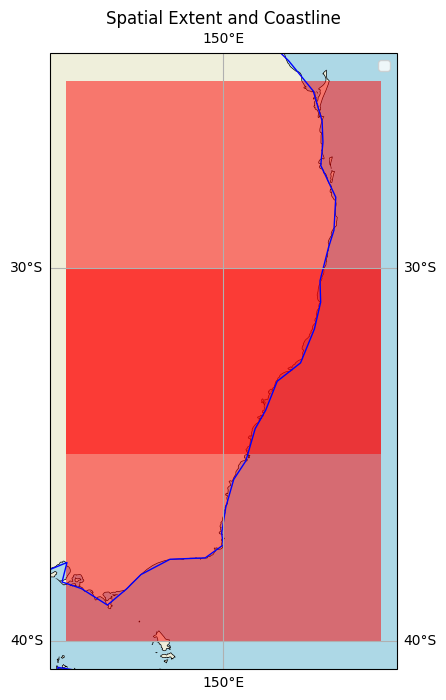

In [8]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
aodn_dataset.get_temporal_extent()

(Timestamp('2009-08-12 02:00:04.499998976'),
 Timestamp('2025-03-31 04:23:51.000009728'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
metadata = aodn_dataset.get_metadata()
metadata

{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0,
  'comment': 'timeOffsetPP: TIME values and time_coverage_start/end global attributes have been applied the following offset : -10 hours.'},
 'TIMESERIES': {'type': 'int32',
  'long_name': 'unique_identifier_for_each_timeseries_feature_instance_in_this_file',
  'cf_role': 'timeseries_id'},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'reference_datum': 'WGS84 coordinate reference system',
  'valid_min': -90.0,
  'valid_max': 90.0},
 'LONGITUDE': {'type': 'double',
  'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'reference_datum': 'WGS84 coordinate reference system',
  'valid_min': -180.0,
  'valid_max': 180.0},
 'NOMINAL_DEPTH': {'type': 'float',
  'standard_name': 'depth',
  'long_name': 'nominal dep

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-02', date_end='2022-12-26', lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110558 entries, 0 to 110557
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   TIME                      110558 non-null  datetime64[ns]
 1   TIMESERIES                110558 non-null  int32         
 2   LATITUDE                  110558 non-null  float64       
 3   LONGITUDE                 110558 non-null  float64       
 4   NOMINAL_DEPTH             110558 non-null  float32       
 5   TEMP                      110558 non-null  float32       
 6   TEMP_quality_control      110558 non-null  float32       
 7   PRES                      89809 non-null   float32       
 8   PRES_quality_control      89809 non-null   float32       
 9   DEPTH                     110553 non-null  float32       
 10  DEPTH_quality_control     110558 non-null  float32       
 11  filename                  110558 non-null  object        
 12  PR

## Create a TIME and scalar/number filter

In [12]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-02', date_end='2022-12-26', scalar_filter = {'site_code': 'BMP070'} )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62217 entries, 0 to 62216
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TIME                      62217 non-null  datetime64[ns]
 1   TIMESERIES                62217 non-null  int32         
 2   LATITUDE                  62217 non-null  float64       
 3   LONGITUDE                 62217 non-null  float64       
 4   NOMINAL_DEPTH             62217 non-null  float32       
 5   TEMP                      62217 non-null  float32       
 6   TEMP_quality_control      62217 non-null  float32       
 7   PRES                      41478 non-null  float32       
 8   PRES_quality_control      41478 non-null  float32       
 9   DEPTH                     62217 non-null  float32       
 10  DEPTH_quality_control     62217 non-null  float32       
 11  filename                  62217 non-null  object        
 12  PRES_REL          

In [13]:
df['NOMINAL_DEPTH'].unique()

array([71.9, 13. , 20. , 36. , 60. , 68. , 28. , 44. , 52. ],
      dtype=float32)

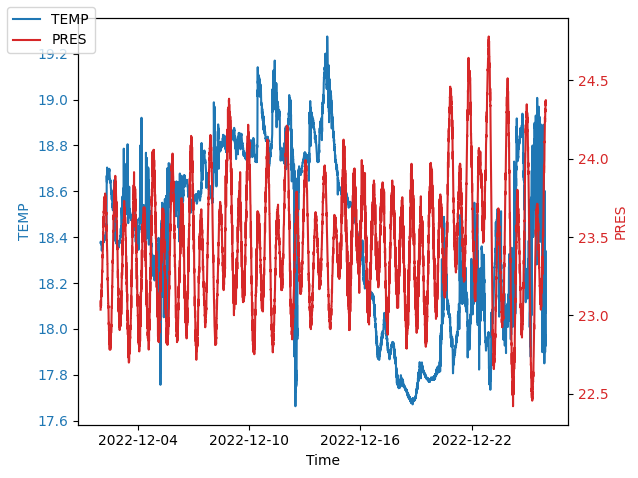

In [14]:
import matplotlib.pyplot as plt

# Filter DataFrame where NOMINAL_DEPTH == 20
filtered_df = df[df['NOMINAL_DEPTH'] == 13]

# Plotting
fig, ax1 = plt.subplots()

# Plot TEMP on the primary y-axis (left)
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('TEMP', color=color)
ax1.plot(filtered_df['TIME'], filtered_df['TEMP'], color=color, label='TEMP')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for PRES
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('PRES', color=color)
ax2.plot(filtered_df['TIME'], filtered_df['PRES'], color=color, label='PRES')
ax2.tick_params(axis='y', labelcolor=color)

# Set a fixed number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust the number of ticks as needed

# Show legend
fig.tight_layout()
fig.legend(loc='upper left')

plt.show()